In [1]:
# Importation des bibliothèques nécessaires
import os
import cv2
import numpy as np
from skimage.feature import hog
import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torch import nn
from torchmetrics import Accuracy
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class PneumoniaDataset(Dataset):
    def __init__(self, path_to_images, categories, img_size=(128, 128)):
        self.path_to_images = path_to_images
        self.categories = categories
        self.img_size = img_size
        self.data = []
        self.load_data()

    def extract_hog_features(self, image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features = hog(gray_image, pixels_per_cell=(
            8, 8), cells_per_block=(2, 2), feature_vector=True)
        return hog_features

    def load_data(self):
        for category in self.categories:
            path = os.path.join(self.path_to_images, category)
            class_num = self.categories.index(category)

            for img in os.listdir(path):
                try:
                    if img.endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(path, img)
                        img_array = cv2.imread(img_path)
                        if img_array is None:
                            print(f"Warning: Could not read image {img_path}")
                            continue
                        features = self.extract_hog_features(
                            cv2.resize(img_array, self.img_size))
                        self.data.append((features, class_num))
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
                    pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, label = self.data[idx]
        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return features, label


In [3]:
class MLP(pl.LightningModule):
    def __init__(self, input_size=8100, hidden_units=(128, 64, 32), num_classes=2):
        super().__init__()

        self.train_acc = Accuracy(task='multiclass', num_classes=num_classes)
        self.valid_acc = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=num_classes)

        all_layers = []
        for hidden_unit in hidden_units:
            all_layers.append(nn.Linear(input_size, hidden_unit))
            all_layers.append(nn.ReLU())
            input_size = hidden_unit

        all_layers.append(nn.Linear(hidden_units[-1], num_classes))
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc, prog_bar=True)
        return loss

    def training_epoch_end(self, outs):
        self.log("train_acc_epoch", self.train_acc.compute())
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        self.log("valid_acc", self.valid_acc, prog_bar=True)
        return loss

    def validation_epoch_end(self, outs):
        self.log("valid_acc_epoch", self.valid_acc.compute())
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc, prog_bar=True)
        return loss

    def test_epoch_end(self, outs):
        self.log("test_acc_epoch", self.test_acc.compute())
        self.test_acc.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [4]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


In [5]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return all_labels, all_preds


In [6]:
DATA_PATH_TRAIN = '../resources/data/train'
CLASS_NAME = ['NORMAL', 'PNEUMONIA']
BATCH_SIZE = 32
NUM_EPOCHS = 20

train_dataset = PneumoniaDataset(DATA_PATH_TRAIN, CLASS_NAME)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

sample_img, _ = train_dataset[0]
# Devrait être torch.Size([8100])
print(f"Sample image shape: {sample_img.shape}")
input_size = sample_img.shape[0]

hidden_units = (128, 64, 32)
num_classes = len(CLASS_NAME)

model = MLP(input_size, hidden_units, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS)

torch.save(model.state_dict(), 'pneumonia_mlp_model.pth')


Sample image shape: torch.Size([8100])
Epoch 1/20, Loss: 0.22413684479160909
Epoch 2/20, Loss: 0.09306937802377288
Epoch 3/20, Loss: 0.07477441581431776
Epoch 4/20, Loss: 0.045541306901894556
Epoch 5/20, Loss: 0.07140526992120305
Epoch 6/20, Loss: 0.04171804933483067
Epoch 7/20, Loss: 0.022644972579108774
Epoch 8/20, Loss: 0.020928036472603016
Epoch 9/20, Loss: 0.059668752691562806
Epoch 10/20, Loss: 0.02387774390032075
Epoch 11/20, Loss: 0.010681587944262192
Epoch 12/20, Loss: 0.026957883007565166
Epoch 13/20, Loss: 0.004373752789171391
Epoch 14/20, Loss: 0.0015753285974629103
Epoch 15/20, Loss: 0.00033931938813591483
Epoch 16/20, Loss: 0.0002116728091419489
Epoch 17/20, Loss: 0.00012930224208246538
Epoch 18/20, Loss: 0.00010474097375161229
Epoch 19/20, Loss: 7.379770489022545e-05
Epoch 20/20, Loss: 5.314705511561604e-05


In [7]:
DATA_PATH_TEST = '../resources/data/test'
CLASS_NAME = ['NORMAL', 'PNEUMONIA']

test_dataset = PneumoniaDataset(DATA_PATH_TEST, CLASS_NAME)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_img, _ = test_dataset[0]
# Assurez-vous que les dimensions de l'image sont correctement obtenues
image_shape = sample_img.shape
print(f"Sample image shape: {image_shape}")

# input_size = image_shape[0] * image_shape[1] * image_shape[2]
input_size = image_shape[0]

hidden_units = (128, 64, 32)  # Utilisez un tuple pour hidden_units
num_classes = len(CLASS_NAME)

model = MLP(input_size, hidden_units, num_classes)
model.load_state_dict(torch.load('pneumonia_mlp_model.pth'))

labels, preds = evaluate_model(model, test_loader)


Sample image shape: torch.Size([8100])


              precision    recall  f1-score   support

      NORMAL       0.97      0.32      0.48       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



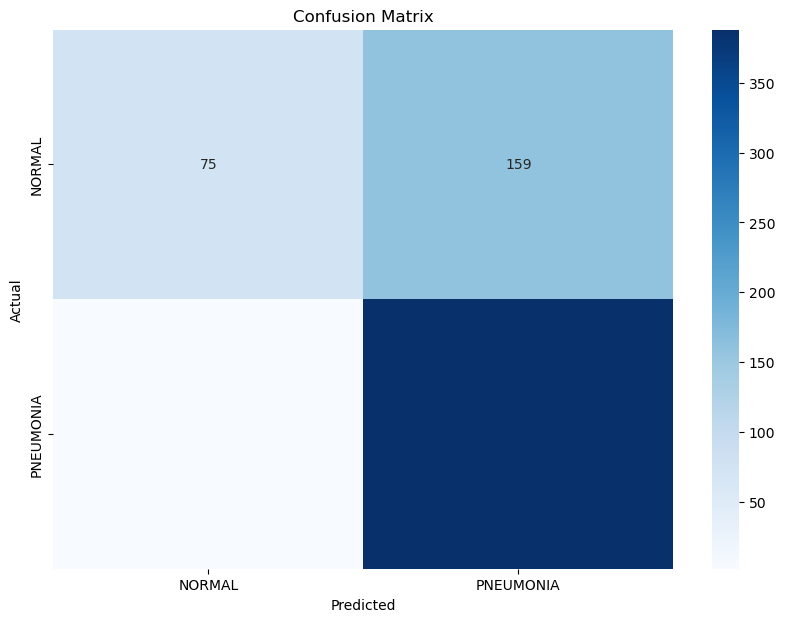

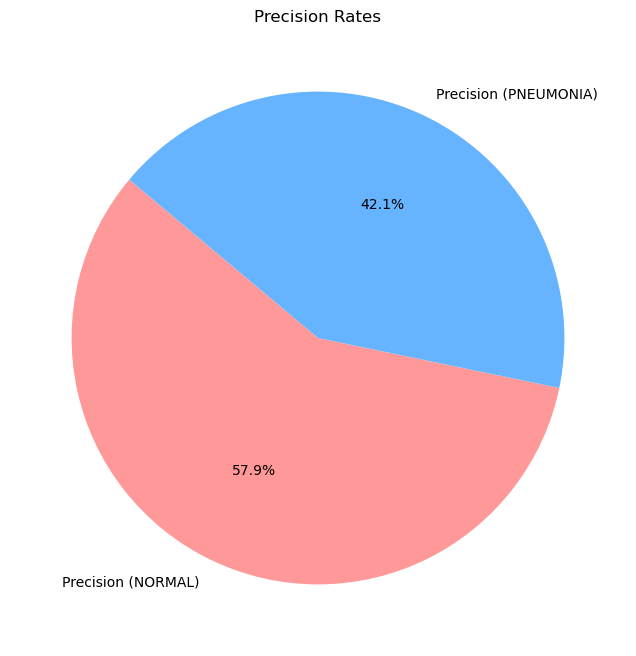

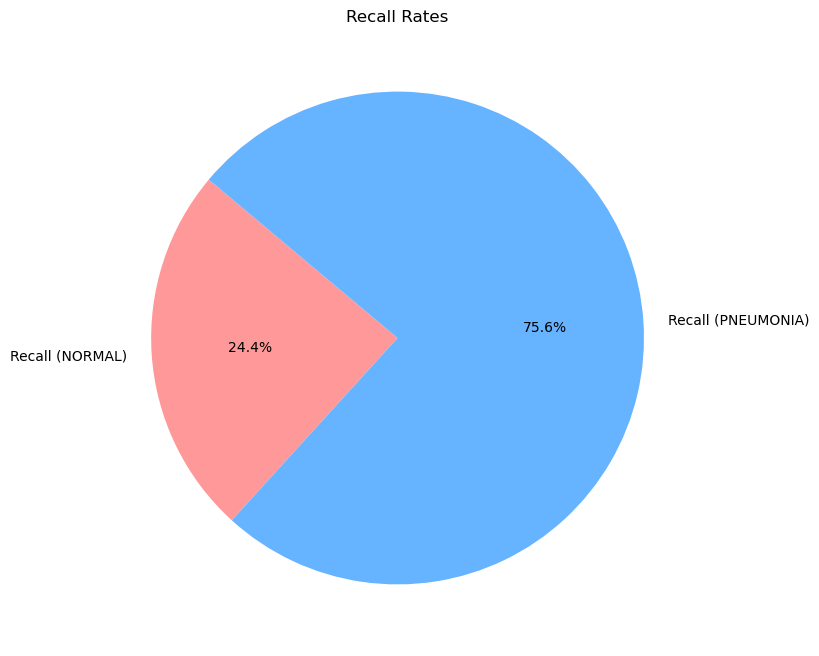

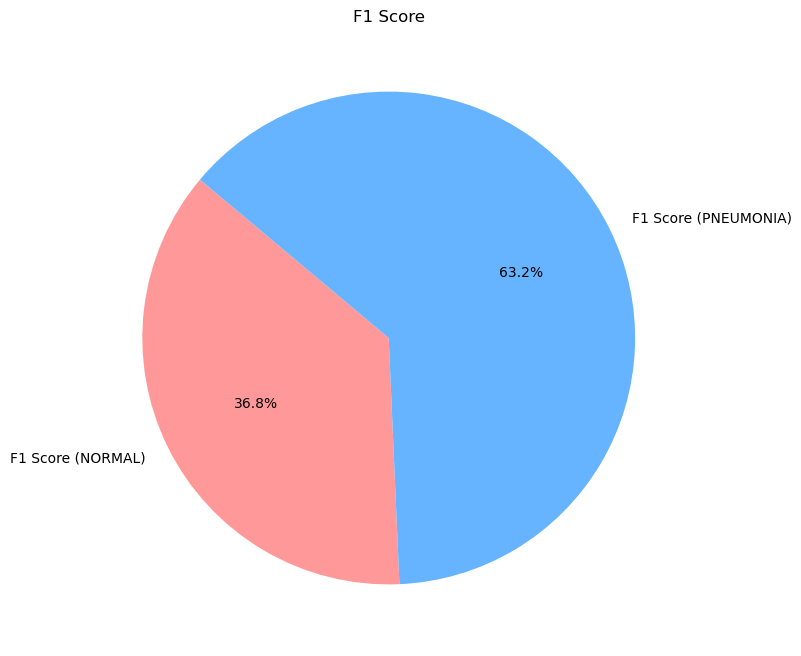

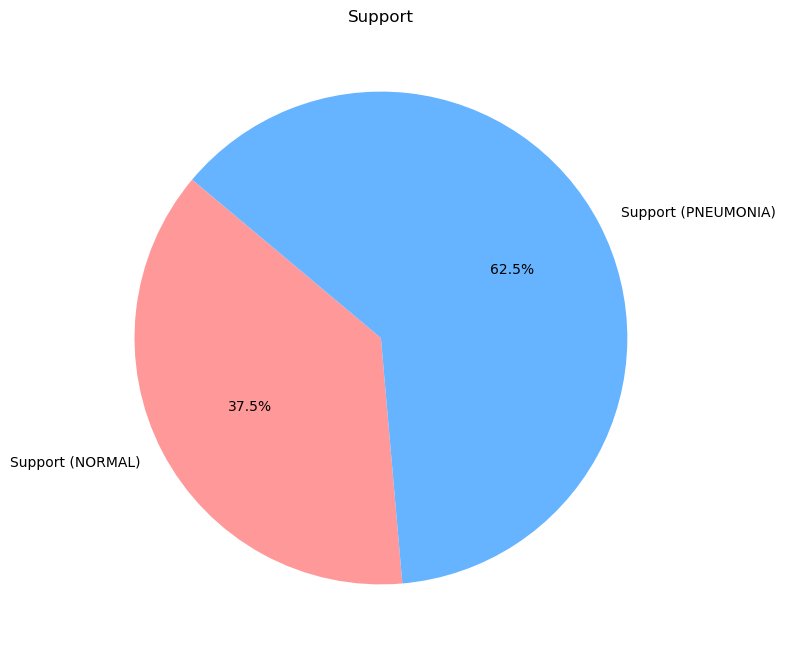

In [8]:
report = classification_report(
    labels, preds, target_names=CLASS_NAME, output_dict=True)
print(classification_report(labels, preds, target_names=CLASS_NAME))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAME, yticklabels=CLASS_NAME)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calcul des taux pour les graphiques ronds
normal_precision = report['NORMAL']['precision']
normal_recall = report['NORMAL']['recall']
pneumonia_precision = report['PNEUMONIA']['precision']
pneumonia_recall = report['PNEUMONIA']['recall']

# Diagrammes circulaires pour la précision
labels = ['Precision (NORMAL)', 'Precision (PNEUMONIA)']
sizes = [normal_precision, pneumonia_precision]
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140)
plt.title('Precision Rates')
plt.show()

# Diagrammes circulaires pour le rappel
labels = ['Recall (NORMAL)', 'Recall (PNEUMONIA)']
sizes = [normal_recall, pneumonia_recall]
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140)
plt.title('Recall Rates')
plt.show()

# Diagrammes circulaires pour les faux positifs
normal_fpr = report['NORMAL']['f1-score']
pneumonia_fpr = report['PNEUMONIA']['f1-score']
labels = ['F1 Score (NORMAL)', 'F1 Score (PNEUMONIA)']
sizes = [normal_fpr, pneumonia_fpr]
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140)
plt.title('F1 Score')
plt.show()

# Diagrammes circulaires pour les faux négatifs
normal_fnr = report['NORMAL']['support']
pneumonia_fnr = report['PNEUMONIA']['support']
labels = ['Support (NORMAL)', 'Support (PNEUMONIA)']
sizes = [normal_fnr, pneumonia_fnr]
colors = ['#ff9999', '#66b3ff']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140)
plt.title('Support')
plt.show()
